In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#Get MNIST data from tensorflow
dataset = tf.contrib.learn.datasets.load_dataset('mnist')
X_train = dataset.train.images
Y_train = dataset.train.labels
Y_train_1hot = np.eye(Y_train.max()+1)[Y_train]

X_test = dataset.test.images
Y_test = dataset.test.labels
Y_test_1hot = np.eye(Y_test.max()+1)[Y_test]

print("X_train shape = {}".format(X_train.shape))
print("Y_train shape = {}".format(Y_train.shape))
print("Y_train_1hot shape = {}".format(Y_test_1hot.shape))
print("X_test shape = {}".format(X_test.shape))
print("Y_test shape = {}".format(Y_test.shape))
print("Y_test_1hot shape = {}".format(Y_test_1hot.shape))

W0725 19:51:46.076634 140458197702464 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0725 19:51:46.078249 140458197702464 deprecation.py:323] From <ipython-input-2-a31f2071ca28>:2: load_dataset (from tensorflow.contrib.learn.python.learn.datasets) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data.
W0725 19:51:46.079510 140458197702464 deprecation.py:323] From /home/gabriel/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/__init__.py:80: load_mnist (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruct

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz


W0725 19:51:49.558007 140458197702464 deprecation.py:323] From /home/gabriel/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


W0725 19:51:50.530707 140458197702464 deprecation.py:323] From /home/gabriel/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


X_train shape = (55000, 784)
Y_train shape = (55000,)
Y_train_1hot shape = (10000, 10)
X_test shape = (10000, 784)
Y_test shape = (10000,)
Y_test_1hot shape = (10000, 10)


In [3]:
#Store data dimensions
N = X_train.shape[0]
H = X_train.shape[1]
pixel_dimensions = int(np.sqrt(H))
num_classes = Y_train.max()+1

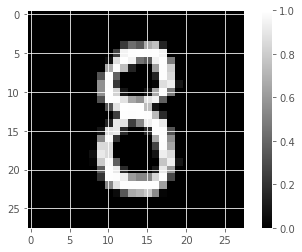

In [4]:
#Plot a random digit to see what the data looks like
index = np.random.randint(N)
img = X_train[index,:].reshape((pixel_dimensions,pixel_dimensions))
plt.figure()
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()
plt.close()

In [5]:
#Set up deep learning parameters
Nlayers = 3
layer_dims = [300,100,10]
activation = tf.nn.relu
initialization = 1e-3

learning_rate = 1e-2
num_iterations = 4000
batch_size = 32
momentum = 0.9
print_every = 100

In [6]:
#Define a convenience function for fully connected layers
def fully_connected(x, output_units=100, activation=tf.identity, std=1e-3,
                   scope='fc', reuse=False):
  """
  args:
      x, (tf tensor), tensor with shape (batch,width,height,channels)
      std, (float/string), std of weight initialization, 'variance' for variance
          scaling
      output_units,(int), number of output units for the layer
      activation, (tf function), tensorflow activation function, e.g. tf.nn.relu
      scope, (string), scope under which to store variables
      reuse, (boolean), whether we want to reuse variables that have already
          been created (i.e. reuse an earilier layer)
  returns:
      a, (tf tensor), the output of the fully_connected layer, has size
          (batch, output_units)
  """
  with tf.variable_scope(scope, reuse=reuse):
    s = x.get_shape().as_list()

    shape = [s[1], output_units]

    if std == 'variance':
      std = np.sqrt(2.0 / shape[0])

    W = tf.get_variable('W', shape=shape, initializer=tf.random_normal_initializer(0.0, std))
    b = tf.get_variable("b", shape=shape[1], initializer=tf.random_normal_initializer(0.0, std))

    h = tf.matmul(x, W) + b
    a = activation(h)
    return a

In [7]:
#Build tensorflow graph
x_tf = tf.placeholder(dtype=tf.float32, shape=[None, H])
y_tf = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

scope = 'layer_1'
num_units = layer_dims[0]
o = fully_connected(x_tf, num_units,activation,initialization,scope)

for i in range(1,Nlayers-1):
    scope = 'layer_{}'.format(i+1)
    num_units = layer_dims[i]
    o = fully_connected(o, num_units, activation,initialization,scope)
    
scope = 'layer_final'
num_units = layer_dims[-1]
o = fully_connected(o, num_units, tf.identity, initialization, scope)

yhat = tf.nn.softmax(o)

In [8]:
#Build loss function and optimizers
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=o,labels=y_tf))

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
            momentum=momentum)

train_op = optimizer.minimize(loss)

W0725 19:52:17.525755 140458197702464 deprecation.py:323] From <ipython-input-8-ce6af6e5baeb>:3: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
#define a convenience function to get data batches during training
def get_batch(xdata, ydata, nbatch):
    N = len(ydata)
    inds = np.random.choice(N, size=nbatch, replace=True)
    xret = xdata[inds,:]
    if len(ydata.shape) == 1:
        yret = ydata[inds]
    else:
        yret = ydata[inds,:]
    return (xret,yret)

In [10]:
#create and initialize the tensorflow session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [11]:
#finally execute the training loop
output = {}
output['train_loss'] = []
output['test_loss'] = []
    
for i in range(num_iterations):
    
    x,y = get_batch(X_train,Y_train_1hot,batch_size)
    
    sess.run(train_op,{x_tf:x,y_tf:y})

    if i%print_every == 0:
        
        l_train = sess.run(loss,{x_tf:x,y_tf:y})
        
        x,y = get_batch(X_test,Y_test_1hot,batch_size)
        l_test = sess.run(loss,{x_tf:x ,y_tf:y})
        
        output['train_loss'].append(l_train)
        output['test_loss'].append(l_test)
        
        print("iteration {}: train loss={}, test loss={}".format(i,l_train,l_test))

iteration 0: train loss=2.301943778991699, test loss=2.3029839992523193
iteration 100: train loss=2.294273853302002, test loss=2.2920641899108887
iteration 200: train loss=2.330824375152588, test loss=2.283853054046631
iteration 300: train loss=2.306964874267578, test loss=2.310879707336426
iteration 400: train loss=2.305490016937256, test loss=2.3395705223083496
iteration 500: train loss=2.314101219177246, test loss=2.275498390197754
iteration 600: train loss=2.277984619140625, test loss=2.3063087463378906
iteration 700: train loss=2.3073513507843018, test loss=2.3031344413757324
iteration 800: train loss=2.2999320030212402, test loss=2.299107074737549
iteration 900: train loss=2.3091936111450195, test loss=2.284424066543579
iteration 1000: train loss=2.2991857528686523, test loss=2.2849831581115723
iteration 1100: train loss=2.3002078533172607, test loss=2.2802445888519287
iteration 1200: train loss=2.298339605331421, test loss=2.303374767303467
iteration 1300: train loss=2.299988508

/home/gabriel/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


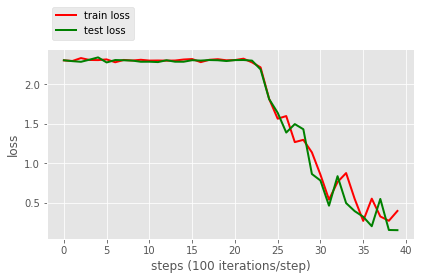

In [12]:
#plot the training and test loss
plt.figure()
plt.plot(output['train_loss'],color='r',linewidth=2,label='train loss')
plt.plot(output['test_loss'],color='g',linewidth=2,label='test loss')
plt.legend()
plt.xlabel('steps ({} iterations/step)'.format(print_every))
plt.ylabel('loss')
lgd = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1)
plt.grid('on')
plt.tight_layout()
plt.show()
plt.close()

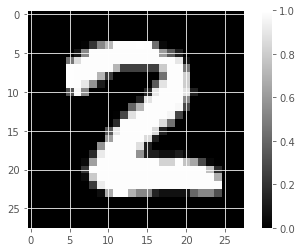

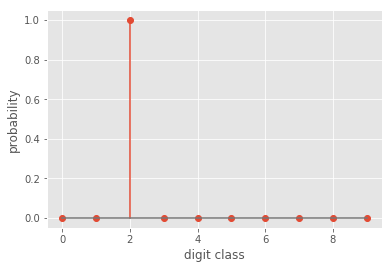

In [13]:
#Plot a random digit and the corresponding network output to see
#how well our network is working
index = np.random.randint(X_test.shape[0])
img = X_test[index,:].reshape((pixel_dimensions,pixel_dimensions))
plt.figure()
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()
plt.close()

#We need a batch dimension so we reshape the vector to (1,784)
input_vector = X_test[index,:].reshape((1,H))
class_probabilities = sess.run(yhat,{x_tf:input_vector})

plt.figure()
plt.stem(class_probabilities[0])
plt.xlabel('digit class')
plt.ylabel('probability')
plt.show()
plt.close()

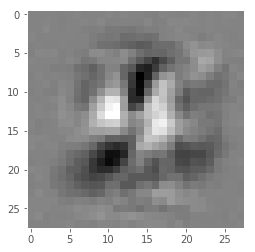

<Figure size 432x288 with 0 Axes>

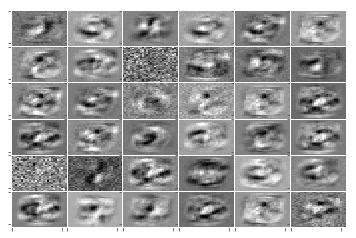

In [14]:
#look at the learned weights
weight_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "layer_1/W")[0]

W = sess.run(weight_var)
W = W.reshape((pixel_dimensions,pixel_dimensions,W.shape[1]))

plt.figure()
plt.imshow(W[:,:,2],cmap='gray')
plt.grid('off')
plt.show()
plt.close()

plt.figure()
Nplots = 6
f, axarr = plt.subplots(Nplots, Nplots)
count = 0
for i in range(Nplots):
    for j in range(Nplots):
        axarr[i, j].imshow(W[:,:,count], cmap='gray')
        axarr[i,j].set_aspect('auto')
        axarr[i,j].grid('off')
        count += 1
        # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
        plt.setp(axarr[i,j].get_xticklabels(), visible=False)
        plt.setp(axarr[i,j].get_yticklabels(), visible=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close()

Accuracy for class 0 = 96.3265306122449%
Accuracy for class 1 = 98.23788546255507%
Accuracy for class 2 = 85.46511627906976%
Accuracy for class 3 = 94.05940594059405%
Accuracy for class 4 = 89.20570264765783%
Accuracy for class 5 = 85.98654708520179%
Accuracy for class 6 = 95.61586638830897%
Accuracy for class 7 = 93.96887159533074%
Accuracy for class 8 = 85.62628336755647%
Accuracy for class 9 = 87.61149653121902%


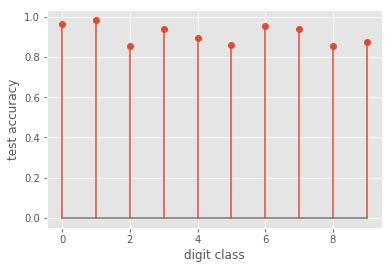

In [15]:
#calculate the accuracy for each class
predicted_probabilities = sess.run(yhat,{x_tf:X_test})
predicted_classes = np.argmax(predicted_probabilities,axis=1)

accuracies = []
for i in range(num_classes):
    class_indices = np.where(Y_test==i)[0]
    total_correct = np.sum(predicted_classes[class_indices]==Y_test[class_indices])
 
    acc = 1.0*total_correct/len(class_indices)
    accuracies.append(acc)
    print("Accuracy for class {} = {}%".format(i,acc*100))
    
plt.figure()
plt.stem(accuracies)
plt.xlabel('digit class')
plt.ylabel('test accuracy')
plt.show()
plt.close()